In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import gpflow as gpf
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
class I:
    Sus = 0
    Inf = 1
    FLat = 2
    SLat = 3
    Rec = 4
    
    N_State_TB = 5

In [4]:
class Model:
    def __init__(self, **exo):
        self.Exo = dict(exo)
    
    def get_y0(self, pars):
        y0 = np.zeros((I.N_State_TB, 2))
        y0[I.Sus] = 0.9
        y0[I.SLat] = 0.1
        y0 /= y0.sum(0)
        y0[:, 0] *= 1 - pars['p_hi']
        y0[:, 1] *= pars['p_hi']
        
        return y0
    
    def calc(self, t, y, pars):
        foi =  pars['beta'] * y[I.Inf].sum() / y.sum()
        
        deaths = pars['r_die'] * y
        births = deaths.sum() * np.array([1 - pars['p_hi'], pars['p_hi']])
        
        rr = np.array([1, pars['rr_act']])
        
        if t < 2025:
            r_acf = 0
        else:
            r_acf = pars['r_acf'] * max(1, (t - 2025) / (2030 - 2025))
        
        return {
            'infection': foi * y[I.Sus],
            'act': rr * pars['r_act'] * y[I.FLat],
            'react': rr * pars['r_react'] * y[I.SLat],
            'rel': pars['r_rel'] * y[I.Rec],
            'lat': pars['r_lat'] * y[I.FLat],
            'rec': pars['r_rec'] * y[I.Inf],
            'acf': r_acf * y[I.Inf],
            'selfcure': pars['r_sc'] * y[I.Inf],
            'deaths': deaths,
            'births': births
        }
    
    def __call__(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        dy = np.zeros_like(y)
        
        calc = self.calc(t, y, pars)
        
        dy[I.Sus] = calc['births'] - calc['infection']
        dy[I.FLat] = calc['infection'] - calc['act'] - calc['lat']
        dy[I.SLat] = calc['lat'] - calc['react'] + calc['selfcure']
        dy[I.Inf] = calc['act'] + calc['react'] + calc['rel'] - calc['rec'] - calc['acf'] - calc['selfcure']
        dy[I.Rec] = calc['rec'] + calc['acf'] - calc['rel']
        dy -= calc['deaths']
        return dy.reshape(-1)
    
    def measure_full(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        calc = self.calc(t, y, pars)
        
        prev = y[I.Inf].sum(0) / y.sum(0)
        odds = prev / (1 - prev)
        
        n = y.sum()
        inc = calc['act'] + calc['react'] + calc['rel']
        
        return {
            'Time': t,
            'Prev': y[I.Inf].sum() / n,
            'Prev_Hi': prev[1],
            'Prev_Lo': prev[0],
            'Pr_Hi': y[:, 1].sum() / n,
            'OR_Hi': odds[1] / odds[0],
            'Inc': inc.sum() / n,
            'CNR': (calc['rec'] + calc['acf']).sum() / n,
            'ACF': calc['acf'].sum() / n,
            'Pr_Lat': y[[I.FLat, I.SLat, I.Rec]].sum() / n
        }
    
    def measure_lite(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        calc = self.calc(t, y, pars)
        
        n = y.sum()
        inc = calc['act'] + calc['react'] + calc['rel']
        
        return {
            'Time': t,
            'Prev': y[I.Inf].sum() / n,
            'Inc': inc.sum() / n,
            'CNR': (calc['rec'] + calc['acf']).sum() / n,
            'Pr_Lat': y[[I.FLat, I.SLat, I.Rec]].sum() / n
        }
    
    def simulate(self, pars, mea_full = True):
        y0 = self.get_y0(pars).reshape(-1)

        ys = solve_ivp(self, [1500, 2020], y0=y0, args=(pars,))
        y1 = ys.y[:, -1]
        
        ys = solve_ivp(self, [2020, 2030], y0=y1, args=(pars,), dense_output=True)
        ts = np.linspace(2020, 2030, 11)
        
        mea = self.measure_full if mea_full else self.measure_lite        
        ms = [mea(t, ys.sol(t), pars) for t in ts]
        
        return ms

In [5]:
m = Model()

In [6]:
with open('out/test/sims_free.json', 'r') as f:
    ps = json.load(f)

sims = list()

for i, p1 in enumerate(ps[:100]):
    p0 = dict(p1)
    p0['r_acf'] = 0

    ms0 = pd.DataFrame(m.simulate(p0))
    ms1 = pd.DataFrame(m.simulate(p1))
    i0, i1 = ms0.Inc.sum(), ms1.Inc.sum()
    p1['Avt'] = 1 - i1 / i0
    p1['Key'] = i
    sims.append(p1)
    
sims = pd.DataFrame(sims)

In [7]:
with open('out/test/sims_10%.json', 'r') as f:
    ps = json.load(f)

sims1 = list()

for i, p1 in enumerate(ps[:100]):
    p0 = dict(p1)
    p0['r_acf'] = 0

    ms0 = pd.DataFrame(m.simulate(p0))
    ms1 = pd.DataFrame(m.simulate(p1))
    i0, i1 = ms0.Inc.sum(), ms1.Inc.sum()
    p1['Avt'] = 1 - i1 / i0
    p1['Key'] = i
    sims1.append(p1)
    
sims1 = pd.DataFrame(sims1)

In [8]:
with open('out/test/sims_30%.json', 'r') as f:
    ps = json.load(f)

sims3 = list()

for i, p1 in enumerate(ps[:100]):
    p0 = dict(p1)
    p0['r_acf'] = 0

    ms0 = pd.DataFrame(m.simulate(p0))
    ms1 = pd.DataFrame(m.simulate(p1))
    i0, i1 = ms0.Inc.sum(), ms1.Inc.sum()
    p1['Avt'] = 1 - i1 / i0
    p1['Key'] = i
    sims3.append(p1)
    
sims3 = pd.DataFrame(sims3)


In [9]:
sims3

,beta,rr_act,r_rec,r_act,r_react,r_rel,r_lat,r_sc,r_die,r_acf,p_hi,Avt,Key
0,8.014262,17.806233,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.039518,0
1,10.196841,11.453603,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.040624,1
2,81.478360,2.713588,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.024693,2
3,67.069741,2.025934,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.023918,3
4,63.744628,1.947828,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.023854,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,70.531441,2.126094,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.024649,95
96,11.240694,7.392479,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.042960,96
97,91.617851,1.663498,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.021635,97
98,21.001644,4.328986,1,0.08,0.0001,0.0001,0.5,0.2,0.014286,0.1,0.3,0.034397,98


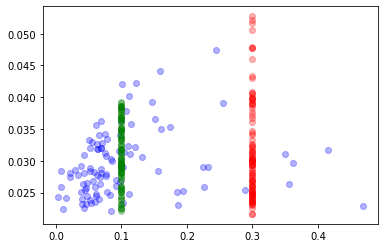

In [10]:
plt.scatter(sims.p_hi, sims.Avt, color='b', alpha = 0.3)
plt.scatter(sims1.p_hi, sims1.Avt, color='g', alpha = 0.3)
plt.scatter(sims3.p_hi, sims3.Avt, color='r', alpha = 0.3)

In [11]:
sims1.Avt.quantile([0.25, 0.5, 0.75]), sims3.Avt.quantile([0.25, 0.5, 0.75])

(0.25    0.027968
 0.50    0.030500
 0.75    0.035079
 Name: Avt, dtype: float64,
 0.25    0.025435
 0.50    0.029884
 0.75    0.036921
 Name: Avt, dtype: float64)

In [36]:
x = sims.p_hi.to_numpy().reshape((-1, 1))
y = sims.Avt.to_numpy().reshape((-1, 1))
data = (x, y)

(100, 1)

In [52]:

kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.Matern32(variance=10.0, lengthscales=2)

model = gpf.models.GPR(data=data, kernel=kernel, mean_function=None)

In [53]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

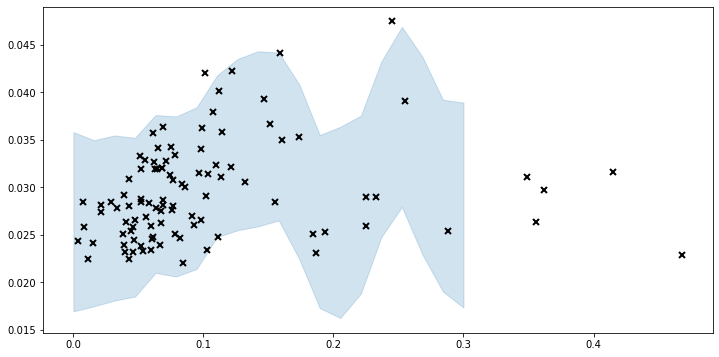

In [55]:
Z = np.linspace(0, 0.3, 20)[:, None]  # Z must be of shape [M, 1]

mean, var = model.predict_y(Z)

plt.figure(figsize=(12, 6))
plt.plot(x, y, "kx", mew=2)
plt.fill_between(
    Z[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

In [25]:
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)